## importowanie pakietów

In [54]:
import os
import seaborn as sns
from scipy import stats
import mne
from mypy.chans import Peakachu
import pandas
import glob
import numpy as np
%matplotlib inline

## ścieżka plików
#### możemy zmieniać tylko zmienną **directory**

In [2]:
directory = "/Users/Gacek/Documents/Python/Projects/Neuroscience/project-datatata"
os.chdir(directory)
files = glob.glob("*epo.fif")

## ładowanie epok i eventów dla N osób

In [9]:
epoch_list = list()
for this_file in range(0,len(files)):
    full_path = os.path.join(directory, files[this_file])
    epochs = mne.read_epochs(full_path, verbose=False)
    epoch_list.append(epochs)

## ładowanie erpów dla N osób

In [10]:
erp_list = list()
for epochs in epoch_list:
    erp_list.append(epochs.average())

## uśredniamy nasze erpy i wyświetlamy gdzie najwięcej się dzieje!

Identiying common channels ...
all channels are corresponding, nothing to do.


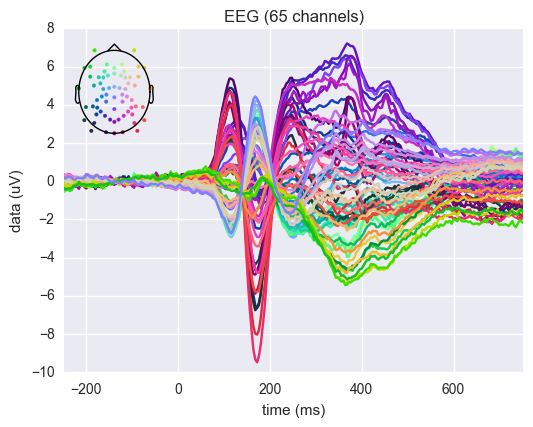

/Users/Gacek/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


In [11]:
avg_erp = mne.grand_average(erp_list)
avg_erp.plot(spatial_colors=True);

#### Zdecydowałem się sprawdzić N170. Poniżej dostajemy główkę oraz informację które kanały zostały wybrane do analizy.
## W tym momencie nie jest idealnie, przy innych wartościach niz N170 wyskakują prędzej czy później błędy.

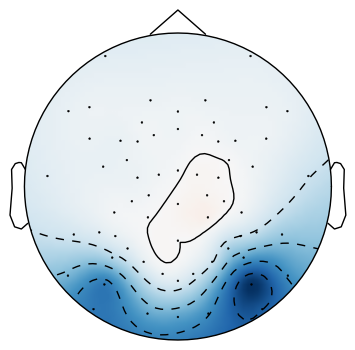

['E39', 'E30', 'E32', 'E43', 'E44']

In [25]:
pika = Peakachu(mode='N170')
pika.fit(avg_erp)
fig = pika.plot_topomap();
pika._chan_names

### Porównujemy wszystkie warunki, więc tworzymy listę z warunkami oraz dwa słowniki dla wartości  peaków i latencji.

In [26]:
conditions = ["car/0", "car/90", "car/180", "face/0", "face/90", "face/180"]
peaks = dict()
lats  = dict()

for cond in conditions:
    peaks[cond] = list()
    lats[cond] = list()
lp_dict = {'lats': lats, 'peaks':peaks}
for cond in conditions:
    peaks[cond] = list()
    lats[cond] = list()
    for each in epoch_list:
        val, lat = pika.transform(each[cond].average())
        peaks[cond].append(val)
        lats[cond].append(lat)

#### Jednym z założeń ANOVY (analizy którą wykorzystamy przy porównywaniu wszystkich warunków) jest normalność rozkładu - sprawdzamy zatem - poniżej piękna tabelka z wynikami oraz werdyktem!

In [27]:
cond_list = []
shap_p_list = []
shap_ver_list = []
for cond in conditions:
    for each in lp_dict:
        shap_result = stats.shapiro(lp_dict[each][cond])[1]
        cond_list.append(cond)
        shap_p_list.append(round(shap_result,2))
ind_shap_p = [[],[]]
for index, each_shap_p in enumerate(shap_p_list):
        ind_shap_p[0].append(index)
        ind_shap_p[1].append(each_shap_p)
        if ind_shap_p[1][index] > 0.05:
            shap_ver_list.append("normal")
        else:
            shap_ver_list.append("not normal")
df_shap_dict = {'cond':cond_list, 'p':shap_p_list, 'verdict':shap_ver_list}
col_shap_list = ['cond', 'p','verdict']
df = pandas.DataFrame(data=df_shap_dict, columns = col_shap_list)
print("Shapiro-Wilk normality test")
df

Shapiro-Wilk normality test


,cond,p,verdict
0,car/0,0.42,normal
1,car/0,0.37,normal
2,car/90,0.10,normal
3,car/90,0.05,not normal
4,car/180,0.46,normal
5,car/180,0.10,normal
6,face/0,0.80,normal
7,face/0,0.28,normal
8,face/90,0.56,normal
9,face/90,0.16,normal


### Lista wartości dla lats i peaks oraz jednoczynnikowa anova dla lats i peaks. Słowniki dla lats i peaks.
#### Ważna uwaga: nie udało mi się zrobić jednoczynnikowej z powtarzanym pomiarem (vide niedorobione scipy) więc musiałem naciągnąć nieco rzeczywistość i potraktowałem każdy warunek jako oddzielną grupę.

In [28]:
lats_list = []
for k in lats.keys():
    lats_list.append(lats[k])
peaks_list = []
for kk in peaks.keys():
    peaks_list.append(peaks[kk])


lats_anova = stats.f_oneway(*lats_list)
if lats_anova[1] < 0.001:
    lats_anova_p = "< 0.001"
else:
    lats_anova_p = "= ", str(round(lats_anova[1],2))
peaks_anova = stats.f_oneway(*peaks_list)
if peaks_anova[1] < 0.001:
    peaks_anova_p = "< 0.001"
else:
    peaks_anova_p = "= " + str(round(peaks_anova[1],2))
lats_title = 'LATS: ' + "F = " + str(round(lats_anova[0],2)) + " ; " + "p " + lats_anova_p
peaks_title = 'PEAKS: ' + "F = " + str(round(peaks_anova[0],2)) + " ; " + "p " + peaks_anova_p
lats_dict = { "car/0": lats_list[0], "car/90": lats_list[1], "car/180": lats_list[2],
            "face/0": lats_list[3], "face/90": lats_list[4], "face/180": lats_list[5]}
peaks_dict = { "car/0": peaks_list[0], "car/90": peaks_list[1], "car/180": peaks_list[2],
            "face/0": peaks_list[3], "face/90": peaks_list[4], "face/180": peaks_list[5]}

### Histogramy dla peaks - w tytule wynik analizy wariancji oraz istotność.

/Users/Gacek/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


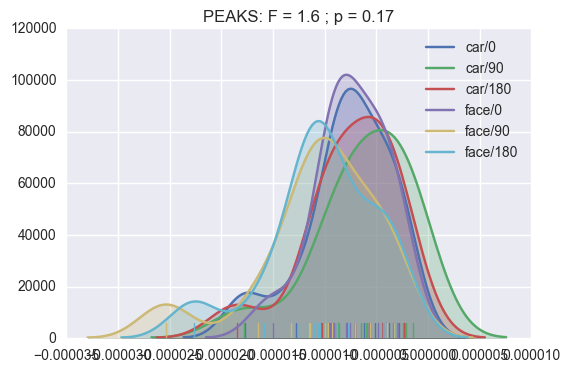

In [29]:
for cnd in conditions:
    sns.distplot(peaks[cnd], kde_kws=dict(shade=True), hist=False, rug=True, label=cnd)
    sns.plt.title(peaks_title)

### Histogramy dla lats - w tytule wynik analizy wariancji oraz istotność.

/Users/Gacek/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


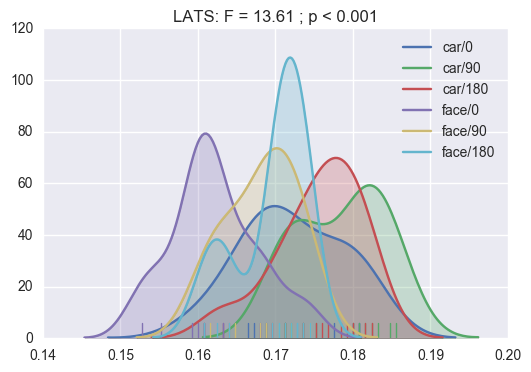

In [30]:
for cnd in conditions:
    sns.distplot(lats[cnd], kde_kws=dict(shade=True), hist=False, rug=True, label=cnd)
    sns.plt.title(lats_title)

### Jeżeli ANOVA okazała się istotna statystycznie, poniższy kod porówna wszystkie możliwe pary i przedstawi wyniki w tabeli. Jeżeli ANOVA jest nieistotna, dostaniemy stosowny komunikat.

In [39]:
if peaks_anova[1] <= 0.05:
    peaks_pairs = []
    for first in range(0,len(peaks_list)):
        for second  in range(first+1,6):
            peaks_pairs.append((conditions[first], conditions[second]))
    first_peaks_list = []
    second_peaks_list = []
    t_peaks_list = []
    p_peaks_list = []
    ver_peaks_list = []
    for first, second in peaks_pairs:
        first_peaks_list.append(first)
        second_peaks_list.append(second)
        ttest_peaks_results = stats.ttest_ind(tuple(peaks_dict[first]),tuple(peaks_dict[second]))
        t_peaks_list.append(round(ttest_peaks_results[0],2))
        p_peaks_list.append(round(ttest_peaks_results[1],2))
        ind_peaks_p = [[],[]]
    for index, each_p in enumerate(p_peaks_list):
            ind_peaks_p[0].append(index)
            ind_peaks_p[1].append(each_p)
            if ind_peaks_p[1][index] > 0.05:
                ver_peaks_list.append(str(first_peaks_list[index]) + " = " + str(second_peaks_list[index]))
            elif ind_peaks_p[1][index] <= 0.05:
                if t_peaks_list[index] > 0:
                    ver_peaks_list.append(str(first_peaks_list[index]) + " > " + str(second_peaks_list[index]))
                else:
                    ver_peaks_list.append(str(first_peaks_list[index]) + " < " + str(second_peaks_list[index]))
    df_peaks_dict = {'cond1':first_peaks_list, 'cond2':second_peaks_list, 't':t_peaks_list, 'p':p_peaks_list, 'verdict':ver_peaks_list}
    col_peaks_list = ['cond1', 'cond2', 't', 'p','verdict']
    peaks_df = pandas.DataFrame(data=df_peaks_dict, columns = col_peaks_list)
    message_peaks = 'Data Frame t-test pairwise comparison for PEAKS.'  
else:
    message_peaks = 'One way ANOVA not significant - no pairwise comparison needed for PEAKS.'
    peaks_df = '*****'
print(message_peaks)
peaks_df

One way ANOVA not significant - no pairwise comparison needed for PEAKS.


'*****'

### Jeżeli ANOVA okazała się istotna statystycznie, poniższy kod porówna wszystkie możliwe pary i przedstawi wyniki w tabeli. Jeżeli ANOVA jest nieistotna, dostaniemy stosowny komunikat.

In [40]:
if lats_anova[1] <= 0.05:
    lats_pairs = []
    for first in range(0,len(lats_list)):
        for second  in range(first+1,6):
            lats_pairs.append((conditions[first], conditions[second]))
    first_lats_list = []
    second_lats_list = []
    t_lats_list = []
    p_lats_list = []
    ver_lats_list = []
    for first, second in lats_pairs:
        first_lats_list.append(first)
        second_lats_list.append(second)
        ttest_lats_results = stats.ttest_ind(tuple(lats_dict[first]),tuple(lats_dict[second]))
        t_lats_list.append(round(ttest_lats_results[0],2))
        p_lats_list.append(round(ttest_lats_results[1],2))
        ind_lats_p = [[],[]]
    for index, each_p in enumerate(p_lats_list):
            ind_lats_p[0].append(index)
            ind_lats_p[1].append(each_p)
            if ind_lats_p[1][index] > 0.05:
                ver_lats_list.append(str(first_lats_list[index]) + " = " + str(second_lats_list[index]))
            elif ind_lats_p[1][index] <= 0.05:
                if t_lats_list[index] > 0:
                    ver_lats_list.append(str(first_lats_list[index]) + " > " + str(second_lats_list[index]))
                else:
                    ver_lats_list.append(str(first_lats_list[index]) + " < " + str(second_lats_list[index]))
    df_lats_dict = {'cond1':first_lats_list, 'cond2':second_lats_list, 't':t_lats_list, 'p':p_lats_list, 'verdict':ver_lats_list}
    col_lats_list = ['cond1', 'cond2', 't', 'p','verdict']
    lats_df = pandas.DataFrame(data=df_lats_dict, columns = col_lats_list)
    message_lats = 'Data Frame t-test pairwise comparison for LATS.'  
else:
    message_lats = 'One way ANOVA not significant - no pairwise comparison needed for LATS.'
    lats_df = '*****'
print(message_lats)
lats_df

Data Frame t-test pairwise comparison for LATS.


,cond1,cond2,t,p,verdict
0,car/0,car/90,-2.55,0.02,car/0 < car/90
1,car/0,car/180,1.79,0.09,car/0 = car/180
2,car/0,face/0,-1.36,0.19,car/0 = face/0
3,car/0,face/90,4.06,0.00,car/0 > face/90
4,car/0,face/180,1.20,0.24,car/0 = face/180
5,car/90,car/180,5.02,0.00,car/90 > car/180
6,car/90,face/0,1.28,0.22,car/90 = face/0
7,car/90,face/90,7.13,0.00,car/90 > face/90
8,car/90,face/180,4.35,0.00,car/90 > face/180
9,car/180,face/0,-3.59,0.00,car/180 < face/0
